# Part 1: Create Landslide Probability Model
UW Geospatial Data Analysis  
CEE498/CEWA599  
Ryan Rasanen & Brek Chiles

In [1]:
# Import all modules 
# These were copied directly from lab 07
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [2]:
from matplotlib_scalebar.scalebar import ScaleBar

### Workflow
* Modify input rasters and use gdalwarp to project, clip, and resample rasters
* Reclassify land cover (GLOB) and lithology (GLIM) datasets - Move description right before landcover and lithology code blocks?
* Use Nowicki et al. (2018) equation to create LS probability model

### CTI
* Original authors of CTI raster multiplied CTI values by 100 "to save" decimal places
* To get the correct CTI value we divide by 100
* Update the datatype
* save CTI as a new raster
* Use gdalwarp updated CTI raster to project, clip, and resample it

In [3]:
# Set relative path to the initial cti file
cti_fn = 'data/cti/cti_initial.tif'

# Now open the cti tif file
cti_src = rio.open(cti_fn)

# Now read the cti file and set masked=True to mask the -32768 values (we now have a numpy masked array)
cti_initial = cti_src.read(1, masked=True)

# Divide cti by 100 as authors multiplied cti by 100 to "save decimal places" so we need to undo that to get the actual cti values
cti_initial_mod = cti_initial/100

In [4]:
# Create a variable for the input rasters profile data
profile = cti_src.profile

# Update the profile to have the needed datatype of float
profile.update(dtype=rio.float64)
profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -32768.0, 'width': 4440, 'height': 4912, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333331163, 0.0, -124.79583333333296,
       0.0, -0.000833333333333115, 49.51666666666807), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [5]:
# Specify output relative filepath (including the output filename)
out_fp = 'data/cti/cti_initial_mod.tif'
out_fp

'data/cti/cti_initial_mod.tif'

In [6]:
# Save the modified cti file as a .tif
if not os.path.exists(out_fp):
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(cti_initial_mod, 1)

In [7]:
# Set name of the input and output files
# input_crs = 'EPSG:4326'    # Do not need to include gdalwarp knows from input file
output_crs = 'EPSG:32610'
cti_input_fn = 'data/cti/cti_initial_mod.tif'
cti_output_fn = 'data/cti/cti_warp.tif'

In [8]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(cti_output_fn):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $cti_input_fn $cti_output_fn

Creating output file that is 1365P x 1250L.
Processing data/cti/cti_initial_mod.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/cti/cti_initial_mod.tif.
Copying nodata values from source data/cti/cti_initial_mod.tif to destination data/cti/cti_warp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
# Set relative path to the warped cti file
cti_warp_fn = 'data/cti/cti_warp.tif'

# Now open the cti tif file
cti_warp_src = rio.open(cti_warp_fn)

# Now read the cti file and set masked=True to mask the -32768 values
cti_warp = cti_warp_src.read(1, masked=True)

# Get the plotting extent
cti_warp_extent = rio.plot.plotting_extent(cti_warp_src)

# returns left, right, bottom, top
cti_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Compute from the GMTED elevation data
* Need to use gdalwarp prior to gdaldem slope
* Use gdalwarp to project, clip, and resample the input elevation raster
* Use gdaldem slope on the elevation raster output by gdalwarp

In [10]:
# Set name of the input and output files
# input_crs = 'EPSG:4326'    # Do not need to include gdalwarp knows from input file
output_crs = 'EPSG:32610'
elev_input_fn = 'data/slope/gmted_elev_initial.tif'
elev_output_fn = 'data/slope/elev_warp.tif'

In [11]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(elev_output_fn):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $elev_input_fn $elev_output_fn

Creating output file that is 1365P x 1250L.
Processing data/slope/gmted_elev_initial.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/slope/gmted_elev_initial.tif.
Copying nodata values from source data/slope/gmted_elev_initial.tif to destination data/slope/elev_warp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [12]:
# Set relative path to the initial elev file
elev_warp_fn = 'data/slope/elev_warp.tif'

# Output slope filename
slope_fn = 'data/slope/slope_warp.tif'

In [13]:
# gdaldem slope input_dem output_slope_map
# Generates a slope map from any GDAL-supported elevation raster
if not os.path.exists(slope_fn):
    !gdaldem slope $elev_warp_fn $slope_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [14]:
# Now open the output slope from gdaldem and assign it to a variable
slope_src = rio.open(slope_fn)

# Now read the slope file
slope = slope_src.read(1, masked=True)

# Get the plotting extent
slope_extent = rio.plot.plotting_extent(slope_src)

# returns left, right, bottom, top
slope_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### PGV
* Use gdalwarp to project, clip, and resample the input PGV raster

In [15]:
# Set name of the input and output files
# input_crs = 'EPSG:4326'    # Do not need to include gdalwarp knows from input file
output_crs = 'EPSG:32610'
pgv_input_fn = 'data/pgv/pgvwsite_csz010.tif'
pgv_output_fn = 'data/pgv/pgv_warp.tif'

In [16]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(pgv_output_fn):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $pgv_input_fn $pgv_output_fn

Creating output file that is 1365P x 1250L.
Processing data/pgv/pgvwsite_csz010.tif [1/1] : 0Using internal nodata values (e.g. -999) for image data/pgv/pgvwsite_csz010.tif.
Copying nodata values from source data/pgv/pgvwsite_csz010.tif to destination data/pgv/pgv_warp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
# Set relative path to the warped pgv file
pgv_warp_fn = 'data/pgv/pgv_warp.tif'

# Now open the pgv tif file
pgv_warp_src = rio.open(pgv_warp_fn)

# Now read the pgv file and set masked=True
pgv_warp = pgv_warp_src.read(1, masked=True)

# Get the plotting extent
pgv_warp_extent = rio.plot.plotting_extent(pgv_warp_src)

# returns left, right, bottom, top
pgv_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Land Cover (GLOB)
* Glim reclassification, lithology values to coefficients
* Save as a new tif file to input into gdalwarp
* Use gdalwarp to project, clip, and resample the input GLIM raster

In [18]:
# Set relative path to the initial cti file
landcover_fn = 'data/landcover/landcover_initial.tif'

# Now open the cti tif file
landcover_src = rio.open(landcover_fn)

# Now read the cti file and set masked=True to mask the -32768 values (we now have a numpy masked array)
landcover_initial = landcover_src.read(1, masked=True)

## GLOB reclassification, cover values to coefficients

In [19]:
glob_copy = landcover_initial.copy()  
glob_copy_flt = np.asarray(glob_copy, dtype=np.float, order='C') # I think we might need to make the integer values floats before reclassifying
glob_copy_flt[np.where(glob_copy_flt == 11.)] = np.nan # Rainfed croplands
glob_copy_flt[np.where(glob_copy_flt == 14.)] = 0.91 # Rainfed croplands
glob_copy_flt[np.where(glob_copy_flt == 20.)] = 0.88 # Mosaic cropland
glob_copy_flt[np.where(glob_copy_flt == 30.)] = 0.78 # Mosaic vegetation
glob_copy_flt[np.where(glob_copy_flt == 40.)] = 0.68 # Closed to open broadleaved evergreen or semideciduous forest
glob_copy_flt[np.where(glob_copy_flt == 50.)] = 0.3 # Closed broadleaved deciduous forest
glob_copy_flt[np.where(glob_copy_flt == 60.)] = 1.77 # Open broadleaved deciduous forest/woodland
glob_copy_flt[np.where(glob_copy_flt == 70.)] = 1.71 # Open broadleaved deciduous forest/woodland
glob_copy_flt[np.where(glob_copy_flt == 90.)] = -1.26 # Closed needleleaved evergreen forest
glob_copy_flt[np.where(glob_copy_flt == 100.)] = 1.5 # Closed to open mixed broadleaved and needleleaved forest
glob_copy_flt[np.where(glob_copy_flt == 110.)] = 0.68 # Mosaic forest or shrubland/grassland
glob_copy_flt[np.where(glob_copy_flt == 120.)] = 1.13 # Mosaic grassland/forest or shrubland
glob_copy_flt[np.where(glob_copy_flt == 130.)] = 0.79 # Closed to open broadleaved or needleleaved, evergreen or deciduous 
glob_copy_flt[np.where(glob_copy_flt == 140.)] = 1.03 # Closed to open herabceous vegetation
glob_copy_flt[np.where(glob_copy_flt == 150.)] = 0.54 # Sparse vegetation
glob_copy_flt[np.where(glob_copy_flt == 160.)] = 2.34 # Closed to open broadleaved forest regulary flooded
glob_copy_flt[np.where(glob_copy_flt == 170.)] = np.nan
glob_copy_flt[np.where(glob_copy_flt == 180.)] = 1.19  
glob_copy_flt[np.where(glob_copy_flt == 190.)] = 0.3  
glob_copy_flt[np.where(glob_copy_flt == 200.)] = -0.06 
glob_copy_flt[np.where(glob_copy_flt == 210.)] = np.nan
glob_copy_flt[np.where(glob_copy_flt == 220.)] = -0.18  
glob_copy_flt[np.where(glob_copy_flt == 230.)] = -1.08
glob_copy_flt

array([[ 0.  ,   nan,   nan, ...,  0.54,  0.54,  0.54],
       [ 0.  ,   nan,   nan, ..., -1.26,  0.79,  0.79],
       [ 0.  ,   nan,   nan, ..., -1.26,  0.79,  0.79],
       ...,
       [ 0.  ,   nan,   nan, ...,  0.68,  0.78,  0.78],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [20]:
glob_reclass_fp = 'data/landcover/glob_reclass.tif'
if not os.path.exists(glob_reclass_fp):
    with rio.open(glob_reclass_fp, "w", **profile) as dst:
        dst.write(glob_copy_flt, 1)

In [21]:
# Set name of the input and output files
output_crs = 'EPSG:32610'
glob_input_fn = 'data/landcover/glob_reclass.tif'
glob_output_fn = 'data/landcover/landcover_warp.tif'

In [22]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(glob_output_fn):
    !gdalwarp -r near -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $glob_input_fn $glob_output_fn

Creating output file that is 1365P x 1250L.
Processing data/landcover/glob_reclass.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/landcover/glob_reclass.tif.
Copying nodata values from source data/landcover/glob_reclass.tif to destination data/landcover/landcover_warp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
# Set relative path to the warped GLOB file
glob_warp_fn = 'data/landcover/landcover_warp.tif'

# Now open the glob tif file
glob_warp_src = rio.open(glob_warp_fn)

# Now read the glob file and set masked=True
glob_warp = glob_warp_src.read(1, masked=True)

# Get the plotting extent
glob_warp_extent = rio.plot.plotting_extent(glob_warp_src)

# returns left, right, bottom, top
glob_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Lithology (GLIM)
* Globcover reclassification, landcover values to coefficients
* Save as a new tif file to input into gdalwarp
* Use gdalwarp to project, clip, and resample the input GLIM raster

In [24]:
# Set relative path to the initial cti file
lithology_fn = 'data/lithology/lithology_initial.tif'

# Now open the cti tif file
lithology_src = rio.open(lithology_fn)

# Now read the cti file and set masked=True to mask the -32768 values (we now have a numpy masked array)
lithology_initial = lithology_src.read(1, masked=True)

In [25]:
glim_copy = lithology_initial.copy()  
glim_copy_flt = np.asarray(glim_copy, dtype=np.float, order='C') # I think we might need to make the integer values floats before reclassifying
glim_copy_flt[np.where(glim_copy_flt == 1.)] = -0.81 # Intermediate Volcanic Rock, vi
glim_copy_flt[np.where(glim_copy_flt == 2.)] = -1.5 # Basic Volcanic Rocks, vb
glim_copy_flt[np.where(glim_copy_flt == 3.)] = -0.78 # Acid Plutonic Rocks, pa
glim_copy_flt[np.where(glim_copy_flt == 4.)] = -1.87 # Metamorphic Rocks, mt
glim_copy_flt[np.where(glim_copy_flt == 5.)] = -3.22 # Unconsolidated Sediments, su
glim_copy_flt[np.where(glim_copy_flt == 6.)] = -1.92 # Siliciclastic Sedimentary Rocks, ss
glim_copy_flt[np.where(glim_copy_flt == 7.)] = -1.88 # Basic Plutonic Rocks, pb
glim_copy_flt[np.where(glim_copy_flt == 8.)] = -1.61 # Intermediate Plutonic Rocks, pi
glim_copy_flt[np.where(glim_copy_flt == 9.)] = -1.36 # Mixed Sedimentary Rocks, sm
glim_copy_flt[np.where(glim_copy_flt == 10.)] = np.nan # Water Bodies, wb
glim_copy_flt[np.where(glim_copy_flt == 11.)] = -1.05 # Pyroclastics, py
glim_copy_flt[np.where(glim_copy_flt == 12.)] = -0.95 # Carbonate Sedimentary Rocks, sc 
glim_copy_flt[np.where(glim_copy_flt == 13.)] = -1.54 # Acid Volcanic Rocks, va
glim_copy_flt[np.where(glim_copy_flt == 14.)] = -0.66 # No Data, nd
glim_copy_flt[np.where(glim_copy_flt == 15.)] = np.nan # Evaporites, ev
glim_copy_flt[np.where(glim_copy_flt == -128.)] = np.nan 
glim_copy_flt

array([[-1.36, -1.36, -1.36, ..., -1.61, -1.61, -1.61],
       [-1.36, -1.36, -1.36, ..., -1.61, -1.61, -1.61],
       [-1.36, -1.36, -1.36, ..., -1.61, -1.61, -1.61],
       ...,
       [  nan,   nan,   nan, ..., -1.5 , -1.5 , -1.5 ],
       [  nan,   nan,   nan, ..., -1.5 , -1.5 , -1.5 ],
       [  nan,   nan,   nan, ..., -1.5 , -1.5 , -1.5 ]])

In [26]:
glim_reclass_fp = 'data/lithology/glim_reclass.tif'
if not os.path.exists(glim_reclass_fp):
    with rio.open(glim_reclass_fp, "w", **profile) as dst:
        dst.write(glim_copy_flt, 1)

In [27]:
# Set name of the input and output files
output_crs = 'EPSG:32610'
glim_input_fn = 'data/lithology/glim_reclass.tif'
glim_output_fn = 'data/lithology/lithology_warp.tif'

In [28]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(glim_output_fn):
    !gdalwarp -r near -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $glim_input_fn $glim_output_fn

Creating output file that is 1365P x 1250L.
Processing data/lithology/glim_reclass.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/lithology/glim_reclass.tif.
Copying nodata values from source data/lithology/glim_reclass.tif to destination data/lithology/lithology_warp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [29]:
# Set relative path to the warped Glim file
glim_warp_fn = 'data/lithology/lithology_warp.tif'

# Now open the glim tif file
glim_warp_src = rio.open(glim_warp_fn)

# Now read the glim file and set masked=True
glim_warp = glim_warp_src.read(1, masked=True)

# Get the plotting extent
glim_warp_extent = rio.plot.plotting_extent(glim_warp_src)

# returns left, right, bottom, top
glim_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

In [30]:
# Set up the Nowicki et al. (2018) equation

In [31]:
# Make a plot

### Plot of input rasters and output probability of landslide

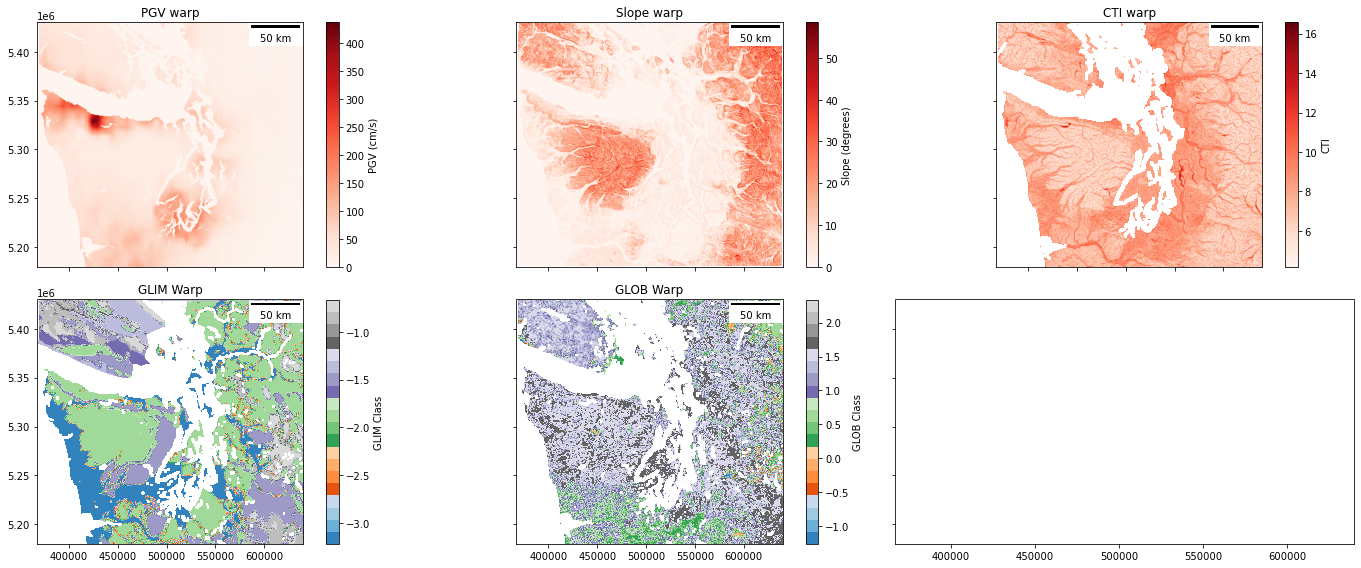

In [32]:
# Plots for each of the raster input parameters (Will choose better colors in the future)

# Create plots of cti for the cti_initial_mod.tif and the cti_warp.tif
f, ax = plt.subplots(2,3, figsize=(20, 8), sharex=True, sharey=True)

# PGV
pgv_warp_plot = ax[0][0].imshow(pgv_warp, cmap='Reds', extent=pgv_warp_extent);
ax[0][0].add_artist(ScaleBar(1.0))
ax[0][0].set_title('PGV warp')
pgv_cbar = f.colorbar(pgv_warp_plot, ax=ax[0][0])
pgv_cbar.set_label('PGV (cm/s)')

# Slope
slope_plot = ax[0][1].imshow(slope, cmap='Reds', extent=slope_extent);
ax[0][1].add_artist(ScaleBar(1.0))
ax[0][1].set_title('Slope warp')
slope_cbar = f.colorbar(slope_plot, ax=ax[0][1]);
slope_cbar.set_label('Slope (degrees)')

# CTI
cti_warp_plot = ax[0][2].imshow(cti_warp, cmap='Reds', extent=cti_warp_extent);
ax[0][2].add_artist(ScaleBar(1.0))
ax[0][2].set_title('CTI warp')
cti_cbar = f.colorbar(cti_warp_plot, ax=ax[0][2])
cti_cbar.set_label('CTI')


# GLIM LITHOLOGY
glim_warp_plot = ax[1][0].imshow(glim_warp, cmap='tab20c', extent=glim_warp_extent);
ax[1][0].add_artist(ScaleBar(1.0))
ax[1][0].set_title('GLIM Warp')
glim_cbar = f.colorbar(glim_warp_plot, ax=ax[1][0])
glim_cbar.set_label('GLIM Class')


# LAND COVER
glim_warp_plot = ax[1][1].imshow(glob_warp, cmap='tab20c', extent=glob_warp_extent);
ax[1][1].add_artist(ScaleBar(1.0))
ax[1][1].set_title('GLOB Warp')
land_cbar = f.colorbar(glim_warp_plot, ax=ax[1][1])
land_cbar.set_label('GLOB Class')


# Probability of Landslide FILLER FOR RIGHT NOW



plt.tight_layout()